# Clinical task generation

In [1]:
# General importations.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math
import string
from random import shuffle,seed,choices
from faker import Faker
from faker.providers.person.en import Provider
import networkx as nx
import itertools

from utils import Utils
from clinical_notes import TaskGenerator,DataSetGenerator

In [2]:
u = Utils()
dg = DataSetGenerator()

## Helper functions

In [31]:
def get_pns_ate(df, verbose = True):
    pns = u.get_pns_direct(df, 
                           y_do_x1 = "True (cause = True)", 
                           y_do_x0 = "True (cause = False)")

    ate = u.get_ate(df,
                    y_do_x1 = "True (cause = True)", 
                    y_do_x0 = "True (cause = False)")
    
    if verbose:
        print("PNS =", pns)
        print("ATE =", ate)
        
    return pns

## Error test (low complexity)

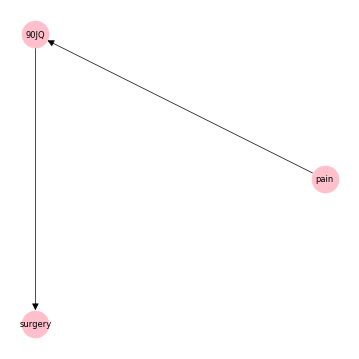


Context: Chronic disease QN6R0M sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 8/10) if they carry allele H2EY, a genetic marker for severe QN6R0M. If the patient self-reports significant pain or the patient has a family history of MV2T, then lab 90JQ will be low (less than 3.14 mg/dL). If 90JQ is low and the patient carries allele RRQ5, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient Steven Burgess. History of Present Illness: Steven Burgess is a 61-year-old male with QN6R0M who presented to the emergency department with acute onset pain that began 3 hours prior to arrival. Pain was rated 3/10. The patient reports the pain has been persistent since onset. The patient took aspirin (250 mg) at home wi

In [4]:
size = [2,2]
tg = TaskGenerator(n_per_bcc = size, 
                   bcc_types = ["cycle"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_patient_history(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [5]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.',
  'True endogenous': {'pain': 0, '90JQ': 1, 'surgery': 0},
  'True exogenous': {'H2EY': 0, 'MV2T': 1, 'RRQ5': 0},
  'True response': 0},
 '90JQ': {'Prompt': 'Given these history and physical notes, will lab 90JQ be low? Begin your response with True or False and be as concise as possible.',
  'True endogenous': {'pain': 0, '90JQ': 1, 'surgery': 0},
  'True exogenous': {'H2EY': 0, 'MV2T': 1, 'RRQ5': 0},
  'True response': 1}}

In [6]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 1, '90JQ': 1, 'surgery': 0}
True exogenous: {'H2EY': 0, 'MV2T': 1, 'RRQ5': 0}
True response: 0

-----------------------

-- ('pain', '90JQ') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will lab 90JQ be low? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 1, '90JQ': 1, 'surgery': 0}
True exogenous: {'H2EY': 0, 'MV2T': 1, 'RRQ5': 0}
True response: 1

-----------------------

-- ('90JQ', 'surgery') --
Prompt: Now suppose that lab 90JQ will be low regardless of all other circumstances. With this new assumpt

In [7]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 0, '90JQ': 1, 'surgery': 0}
True exogenous: {'H2EY': 0, 'MV2T': 1, 'RRQ5': 0}
True response: 0

-----------------------

-- ('pain', '90JQ') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will lab 90JQ be low? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 0, '90JQ': 1, 'surgery': 0}
True exogenous: {'H2EY': 0, 'MV2T': 1, 'RRQ5': 0}
True response: 1

-----------------------

-- ('90JQ', 'surgery') --
Prompt: Now suppose that lab 90JQ will not be low regardless of all other circumstances. With this new assumption, will t

In [8]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,90JQ,surgery
0,1,1,0
1,1,1,1
2,0,1,1
3,0,0,0
4,0,0,0


,H2EY,MV2T,RRQ5
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


In [9]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- pain = 1 --


,pain,90JQ,surgery
0,1,1,0
1,1,1,1
2,1,1,1
3,1,1,1
4,1,1,1


,H2EY,MV2T,RRQ5
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1



-- 90JQ = 1 --


,pain,90JQ,surgery
0,1,1,0
1,1,1,1
2,0,1,1
3,0,1,1
4,0,1,1


,H2EY,MV2T,RRQ5
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


In [10]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- pain = 0 --


,pain,90JQ,surgery
0,0,0,0
1,0,1,1
2,0,1,1
3,0,0,0
4,0,0,0


,H2EY,MV2T,RRQ5
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1



-- 90JQ = 0 --


,pain,90JQ,surgery
0,1,0,0
1,1,0,0
2,0,0,0
3,0,0,0
4,0,0,0


,H2EY,MV2T,RRQ5
0,1,0,0
1,1,1,1
2,0,1,1
3,0,0,1
4,0,0,1


## Error test (moderate complexity)

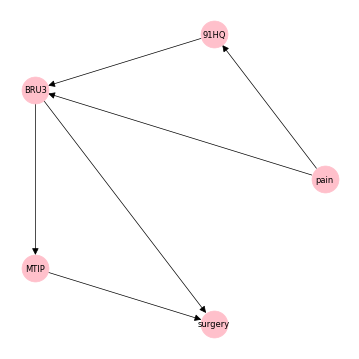


Context: Chronic disease ZSBGT5 sometimes requires surgical intervention, depending on genetics, patient history, vital signs, and lab results. The patient will experience significant pain (rated greater than or equal to 9/10) if they carry allele 38OE, a genetic marker for severe ZSBGT5. If the patient self-reports significant pain or the patient has a family history of 3AP7, then vital 91HQ will be low (less than 0.83 mg/dL). If the patient self-reports significant pain or 91HQ is low or the patient carries allele OL8I, then vital BRU3 will be elevated (greater than 2.81 mg/dL). If BRU3 is elevated or the patient carries allele YCNU, then lab MTIP will be elevated (greater than 2.39 mg/dL). If BRU3 is elevated and MTIP is elevated and the patient has previously received surgery for Y687, then the surgeon will recommend surgery. Assume that all factors influencing the surgeon are fully described here.

Patient history: Now, we will review the history and physical notes for patient Br

In [11]:
size = [3,3]
tg = TaskGenerator(n_per_bcc = size, 
                   bcc_types = ["cycle"]*len(size))
context = tg.get_causal_context()
patient_history = tg.get_patient_history(n_extra_vars = 2)
print()
print("Context:", context)
print()
print("Patient history:", patient_history)
print()
print("- Global cause-effect pairs:", tg.get_global())
print("- Local cause-effect pairs:", tg.get_local())
print("- Compositions:", tg.get_compositions())

In [12]:
print()
print("- Factual queries:")
display(tg.get_factual_queries())


- Factual queries:


{'surgery': {'Prompt': 'Given these history and physical notes, will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.',
  'True endogenous': {'pain': 1,
   '91HQ': 1,
   'BRU3': 1,
   'MTIP': 1,
   'surgery': 1},
  'True exogenous': {'38OE': 1, '3AP7': 0, 'OL8I': 0, 'YCNU': 0, 'Y687': 1},
  'True response': 1},
 'BRU3': {'Prompt': 'Given these history and physical notes, will vital BRU3 be elevated? Begin your response with True or False and be as concise as possible.',
  'True endogenous': {'pain': 1,
   '91HQ': 1,
   'BRU3': 1,
   'MTIP': 1,
   'surgery': 1},
  'True exogenous': {'38OE': 1, '3AP7': 0, 'OL8I': 0, 'YCNU': 0, 'Y687': 1},
  'True response': 1}}

In [13]:
cf_1, cf_0 = tg.get_counterfactual_queries()
print("- Counterfactual queries (cause = True):")
for key,val in cf_1.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = True):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 1, '91HQ': 1, 'BRU3': 1, 'MTIP': 1, 'surgery': 1}
True exogenous: {'38OE': 1, '3AP7': 0, 'OL8I': 0, 'YCNU': 0, 'Y687': 1}
True response: 1

-----------------------

-- ('pain', 'BRU3') --
Prompt: Now suppose that the patient will be in significant pain regardless of all other circumstances. With this new assumption, will vital BRU3 be elevated? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 1, '91HQ': 1, 'BRU3': 1, 'MTIP': 1, 'surgery': 1}
True exogenous: {'38OE': 1, '3AP7': 0, 'OL8I': 0, 'YCNU': 0, 'Y687': 1}
True response: 1

-----------------------

-- ('BRU3', 'surgery') --
Prompt: Now

In [14]:
print("- Counterfactual queries (cause = False):")
for key,val in cf_0.items():
    print("\n-----------------------")
    print("\n-- {} --".format(key))
    print("Prompt:", val.get("Prompt"))
    print("True endogenous:", val.get("True endogenous"))
    print("True exogenous:", val.get("True exogenous"))
    print("True response:", val.get("True response"))
print("\n-----------------------")

- Counterfactual queries (cause = False):

-----------------------

-- ('pain', 'surgery') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will the surgeon recommend surgery? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 0, '91HQ': 0, 'BRU3': 0, 'MTIP': 0, 'surgery': 0}
True exogenous: {'38OE': 1, '3AP7': 0, 'OL8I': 0, 'YCNU': 0, 'Y687': 1}
True response: 0

-----------------------

-- ('pain', 'BRU3') --
Prompt: Now suppose that the patient will not be in pain regardless of all other circumstances. With this new assumption, will vital BRU3 be elevated? Begin your response with True or False and be as concise as possible.
True endogenous: {'pain': 0, '91HQ': 0, 'BRU3': 0, 'MTIP': 0, 'surgery': 0}
True exogenous: {'38OE': 1, '3AP7': 0, 'OL8I': 0, 'YCNU': 0, 'Y687': 1}
True response: 0

-----------------------

-- ('BRU3', 'surgery') --
Prompt: Now suppose that v

In [15]:
# Test observational data generation.
df_obs, df_noise = tg.sample_scm(n = 5,
                                 intervene_node = None,
                                 intervene_value = 0)
display(df_obs.head())
display(df_noise.head())

,pain,91HQ,BRU3,MTIP,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,38OE,3AP7,OL8I,YCNU,Y687
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [16]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 1
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- BRU3 = 1 --


,pain,91HQ,BRU3,MTIP,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,38OE,3AP7,OL8I,YCNU,Y687
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0



-- pain = 1 --


,pain,91HQ,BRU3,MTIP,surgery
0,1,1,1,1,0
1,1,1,1,1,0
2,1,1,1,1,1
3,1,1,1,1,0
4,1,1,1,1,0


,38OE,3AP7,OL8I,YCNU,Y687
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [20]:
# Test counterfactual data generation.
causes = set([x[0] for x in [tg.get_global()]+tg.get_local()])
intervene_value = 0
for cause in causes:
    print("\n-- {} = {} --".format(cause,intervene_value))
    df_obs, df_noise = tg.sample_scm(n = 5,
                                     intervene_node = cause,
                                     intervene_value = intervene_value)
    display(df_obs.head())
    display(df_noise.head())


-- BRU3 = 0 --


,pain,91HQ,BRU3,MTIP,surgery
0,1,1,0,1,0
1,1,1,0,0,0
2,0,1,0,0,0
3,0,0,0,1,0
4,0,0,0,1,0


,38OE,3AP7,OL8I,YCNU,Y687
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0



-- pain = 0 --


,pain,91HQ,BRU3,MTIP,surgery
0,0,0,0,1,0
1,0,1,1,1,0
2,0,1,1,1,1
3,0,0,1,1,0
4,0,0,1,1,0


,38OE,3AP7,OL8I,YCNU,Y687
0,1,0,0,1,0
1,1,1,1,0,0
2,0,1,1,0,1
3,0,0,1,1,0
4,0,0,1,1,0


In [21]:
glo = [tg.get_global()]
loc = tg.get_local()
comp = tg.get_compositions()

print(glo)
print(loc)
print(comp)

[('pain', 'surgery')]
[('pain', 'BRU3'), ('BRU3', 'surgery')]
[[('pain', 'BRU3'), ('BRU3', 'surgery')]]


In [22]:
# Get PNS and compare to ATE.
results_dict = dict()
for n in [5,10,50,100,500,1000,5000]:
    pair_dict = dict()
    for pair in glo+loc:
        df_cf, df_noise = tg.sample_scm(n = n,
                                        intervene_node = pair[0],
                                        intervene_value = 1)
        df_cf.rename(columns={pair[1]: 'True (cause = True)'}, inplace = True)
        df_cf_0, df_noise = tg.sample_scm(n = n,
                                          intervene_node = pair[0],
                                          intervene_value = 0)
        df_cf["True (cause = False)"] = df_cf_0[pair[1]]
        display(df_cf.head(5))
        print("\n-- {} | n = {} --".format(pair,n))
        pns = get_pns_ate(df_cf)
        pair_dict[pair] = pns
    results_dict[n] = pair_dict

,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 5 --
PNS = 0.0
ATE = 0.0


,pain,91HQ,True (cause = True),MTIP,surgery,True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,0,1



-- ('pain', 'BRU3') | n = 5 --
PNS = 0.2
ATE = 0.19999999999999996


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,0,1,1,0,0
4,0,0,1,1,0,0



-- ('BRU3', 'surgery') | n = 5 --
PNS = 0.2
ATE = 0.2


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 10 --
PNS = 0.0
ATE = 0.0


,pain,91HQ,True (cause = True),MTIP,surgery,True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,1,1
4,1,1,1,1,1,1



-- ('pain', 'BRU3') | n = 10 --
PNS = 0.1
ATE = 0.09999999999999998


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,1,1,1,1,0
4,0,1,1,1,1,0



-- ('BRU3', 'surgery') | n = 10 --
PNS = 0.6
ATE = 0.6


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,1
2,1,1,1,1,0,0
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 50 --
PNS = 0.06
ATE = 0.06


,pain,91HQ,True (cause = True),MTIP,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,1,1
2,1,1,1,1,0,1
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', 'BRU3') | n = 50 --
PNS = 0.18
ATE = 0.18000000000000005


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,0,1,1,1,0,0
3,0,1,1,1,0,0
4,0,0,1,1,1,0



-- ('BRU3', 'surgery') | n = 50 --
PNS = 0.52
ATE = 0.52


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 100 --
PNS = 0.13
ATE = 0.13


,pain,91HQ,True (cause = True),MTIP,surgery,True (cause = False)
0,1,1,1,1,1,1
1,1,1,1,1,0,1
2,1,1,1,1,1,1
3,1,1,1,1,0,1
4,1,1,1,1,1,1



-- ('pain', 'BRU3') | n = 100 --
PNS = 0.26
ATE = 0.26


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,1,1,1,0,0
4,0,1,1,1,1,0



-- ('BRU3', 'surgery') | n = 100 --
PNS = 0.51
ATE = 0.51


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'surgery') | n = 500 --
PNS = 0.138
ATE = 0.138


,pain,91HQ,True (cause = True),MTIP,surgery,True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,1,1,1,1,1,1
3,1,1,1,1,0,0
4,1,1,1,1,1,1



-- ('pain', 'BRU3') | n = 500 --
PNS = 0.25
ATE = 0.25


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,1,0
1,1,1,1,1,0,0
2,0,1,1,1,1,0
3,0,0,1,1,0,0
4,0,1,1,1,1,0



-- ('BRU3', 'surgery') | n = 500 --
PNS = 0.512
ATE = 0.512


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,1,1,1,1,0,0
3,1,1,1,1,1,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 1000 --
PNS = 0.12
ATE = 0.12


,pain,91HQ,True (cause = True),MTIP,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,1,0
2,1,1,1,1,0,1
3,1,1,1,1,1,0
4,1,1,1,1,0,1



-- ('pain', 'BRU3') | n = 1000 --
PNS = 0.251
ATE = 0.251


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,1,0
2,0,0,1,1,0,0
3,0,0,1,1,1,0
4,0,1,1,1,0,0



-- ('BRU3', 'surgery') | n = 1000 --
PNS = 0.492
ATE = 0.492


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,1,1,1,1,1,0
3,1,1,1,1,0,0
4,1,1,1,1,0,0



-- ('pain', 'surgery') | n = 5000 --
PNS = 0.123
ATE = 0.123


,pain,91HQ,True (cause = True),MTIP,surgery,True (cause = False)
0,1,1,1,1,0,1
1,1,1,1,1,0,1
2,1,1,1,1,1,0
3,1,1,1,1,0,1
4,1,1,1,1,0,1



-- ('pain', 'BRU3') | n = 5000 --
PNS = 0.2456
ATE = 0.24560000000000004


,pain,91HQ,BRU3,MTIP,True (cause = True),True (cause = False)
0,1,1,1,1,0,0
1,1,1,1,1,0,0
2,0,0,1,1,1,0
3,0,1,1,1,0,0
4,0,1,1,1,0,0



-- ('BRU3', 'surgery') | n = 5000 --
PNS = 0.4914
ATE = 0.4914


In [23]:
for n,res in results_dict.items():
    print("\n-- n = {} --".format(n))
    comp_pns = 1
    for pair,pns in res.items():
        if pair == glo[0]:
            global_pns = pns
        else:
            comp_pns *= pns
    print("Global PNS  =", global_pns)
    print("Composition =", comp_pns)


-- n = 5 --
Global PNS  = 0.0
Composition = 0.04000000000000001

-- n = 10 --
Global PNS  = 0.0
Composition = 0.06

-- n = 50 --
Global PNS  = 0.06
Composition = 0.0936

-- n = 100 --
Global PNS  = 0.13
Composition = 0.1326

-- n = 500 --
Global PNS  = 0.138
Composition = 0.128

-- n = 1000 --
Global PNS  = 0.12
Composition = 0.123492

-- n = 5000 --
Global PNS  = 0.123
Composition = 0.12068784


## Generate dataset

In [35]:
# 4 levels of graphical complexity (captured by BCC size).
# 10 tasks per graphical complexity level.
# 100 samples per task.
# = 4k subtasks.
graph_sizes = [[2,2,2],[3,3,3],[4,4,4],[5,5,5]]
n_tasks_per_size = 2
n_samples_per_task = 100

df = dg.get_dataset(graph_sizes = graph_sizes,
                    n_tasks_per_size = n_tasks_per_size,
                    n_samples_per_task = n_samples_per_task)

display(df)

,Task ID,Context ID,Sample ID,Nodes per BCC,Causal context,DAG adjacency matrix,DAG nodes,CCT adjacency matrix,CCT nodes,Global quantity,Local quantities,Compositions,Patient history,Factual queries,Counterfactual queries (cause = True),Counterfactual queries (cause = False)
0,0.0.2,0,0,2,Chronic disease 091MTT sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, E7Q1, S0GL, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, E7Q1, S0GL, surgery]","(pain, surgery)","[(pain, E7Q1), (pain, S0GL), (E7Q1, S0GL), (E7...","[[(pain, E7Q1), (E7Q1, S0GL), (S0GL, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
1,0.1.2,0,1,2,Chronic disease 091MTT sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, E7Q1, S0GL, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, E7Q1, S0GL, surgery]","(pain, surgery)","[(pain, E7Q1), (pain, S0GL), (E7Q1, S0GL), (E7...","[[(pain, E7Q1), (E7Q1, S0GL), (S0GL, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
2,0.2.2,0,2,2,Chronic disease 091MTT sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, E7Q1, S0GL, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, E7Q1, S0GL, surgery]","(pain, surgery)","[(pain, E7Q1), (pain, S0GL), (E7Q1, S0GL), (E7...","[[(pain, E7Q1), (E7Q1, S0GL), (S0GL, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
3,0.3.2,0,3,2,Chronic disease 091MTT sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, E7Q1, S0GL, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, E7Q1, S0GL, surgery]","(pain, surgery)","[(pain, E7Q1), (pain, S0GL), (E7Q1, S0GL), (E7...","[[(pain, E7Q1), (E7Q1, S0GL), (S0GL, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
4,0.4.2,0,4,2,Chronic disease 091MTT sometimes requires surg...,"[[0, 1, 0, 0], [0, 0, 1, 0], [0, 0, 0, 1], [0,...","[pain, E7Q1, S0GL, surgery]","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, E7Q1, S0GL, surgery]","(pain, surgery)","[(pain, E7Q1), (pain, S0GL), (E7Q1, S0GL), (E7...","[[(pain, E7Q1), (E7Q1, S0GL), (S0GL, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
795,7.95.5,7,95,5,Chronic disease 14M40N sometimes requires surg...,"[[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[pain, W0XI, B073, TPUC, VZTE, I7EB, PDNV, ED3...","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, VZTE, APCR, surgery]","(pain, surgery)","[(pain, VZTE), (pain, APCR), (VZTE, APCR), (VZ...","[[(pain, VZTE), (VZTE, APCR), (APCR, surgery)]...","Now, we will review the history and physical n...",{'surgery': {'Prompt': 'Given these history an...,"{('pain', 'surgery'): {'Prompt': 'Now suppose ...","{('pain', 'surgery'): {'Prompt': 'Now suppose ..."
796,7.96.5,7,96,5,Chronic disease 14M40N sometimes requires surg...,"[[0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0], [0, ...","[pain, W0XI, B073, TPUC, VZTE, I7EB, PDNV, ED3...","[[0.0, 1.0, 1.0, 1.0], [0.0, 0.0, 1.0, 1.0], [...","[pain, VZTE, APCR, surgery]","(pain, surgery)","[(pain, VZTE), (pain,

In [36]:
# Process prompts.
df_factual, df_cf = dg.process_prompts(df)
display(df_factual)
display(df_cf)

,Context ID,Task ID,Effect,Prompt,True
0,0,0.0.2,surgery,Chronic disease 091MTT sometimes requires surg...,0
1,0,0.0.2,E7Q1,Chronic disease 091MTT sometimes requires surg...,1
2,0,0.0.2,S0GL,Chronic disease 091MTT sometimes requires surg...,1
3,0,0.1.2,surgery,Chronic disease 091MTT sometimes requires surg...,0
4,0,0.1.2,E7Q1,Chronic disease 091MTT sometimes requires surg...,0
...,...,...,...,...,...
2395,7,7.98.5,VZTE,Chronic disease 14M40N sometimes requires surg...,1
2396,7,7.98.5,APCR,Chronic disease 14M40N sometimes requires surg...,1
2397,7,7.99.5,surgery,Chronic disease 14M40N sometimes requires surg...,0
2398,7,7.99.5,VZTE,Chronic disease 14M40N sometimes requires surg...,1


,Context ID,Task ID,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0,0.0.2,"(pain, surgery)",pain,surgery,Chronic disease 091MTT sometimes requires surg...,0,Chronic disease 091MTT sometimes requires surg...,0
1,0,0.0.2,"(pain, E7Q1)",pain,E7Q1,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
2,0,0.0.2,"(pain, S0GL)",pain,S0GL,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
3,0,0.0.2,"(E7Q1, S0GL)",E7Q1,S0GL,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
4,0,0.0.2,"(E7Q1, surgery)",E7Q1,surgery,Chronic disease 091MTT sometimes requires surg...,0,Chronic disease 091MTT sometimes requires surg...,0
...,...,...,...,...,...,...,...,...,...
4795,7,7.99.5,"(pain, VZTE)",pain,VZTE,Chronic disease 14M40N sometimes requires surg...,1,Chronic disease 14M40N sometimes requires surg...,1
4796,7,7.99.5,"(pain, APCR)",pain,APCR,Chronic disease 14M40N sometimes requires surg...,1,Chronic disease 14M40N sometimes requires surg...,1
4797,7,7.99.5,"(VZTE, APCR)",VZTE,APCR,Chronic disease 14M40N sometimes requires surg...,1,Chronic disease 14M40N sometimes requires surg...,1
4798,7,7.99.5,"(VZTE, surgery)",VZTE,surgery,Chronic disease 14M40N sometimes requires surg...,0,Chronic disease 14M40N sometimes requires surg...,0


In [37]:
df_cf["Context ID"].value_counts()

Context ID
0    600
1    600
2    600
3    600
4    600
5    600
6    600
7    600
Name: count, dtype: int64

In [38]:
df_cf_0 = df_cf[df_cf["Context ID"] == 0]
df_cf_0

,Context ID,Task ID,Cause-effect pair,Cause,Effect,Prompt (cause = True),True (cause = True),Prompt (cause = False),True (cause = False)
0,0,0.0.2,"(pain, surgery)",pain,surgery,Chronic disease 091MTT sometimes requires surg...,0,Chronic disease 091MTT sometimes requires surg...,0
1,0,0.0.2,"(pain, E7Q1)",pain,E7Q1,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
2,0,0.0.2,"(pain, S0GL)",pain,S0GL,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
3,0,0.0.2,"(E7Q1, S0GL)",E7Q1,S0GL,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
4,0,0.0.2,"(E7Q1, surgery)",E7Q1,surgery,Chronic disease 091MTT sometimes requires surg...,0,Chronic disease 091MTT sometimes requires surg...,0
...,...,...,...,...,...,...,...,...,...
595,0,0.99.2,"(pain, E7Q1)",pain,E7Q1,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
596,0,0.99.2,"(pain, S0GL)",pain,S0GL,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
597,0,0.99.2,"(E7Q1, S0GL)",E7Q1,S0GL,Chronic disease 091MTT sometimes requires surg...,1,Chronic disease 091MTT sometimes requires surg...,0
598,0,0.99.2,"(E7Q1, surgery)",E7Q1,surgery,Chronic disease 091MTT sometimes requires surg...,0,Chronic disease 091MTT sometimes requires surg...,0


In [45]:
df_cf_0["Cause-effect pair"].unique()

array([('pain', 'surgery'), ('pain', 'E7Q1'), ('pain', 'S0GL'),
       ('E7Q1', 'S0GL'), ('E7Q1', 'surgery'), ('S0GL', 'surgery')],
      dtype=object)

In [48]:
context_dict = dict()
for context_id in df_cf["Context ID"].unique():
    df_context = df_cf[df_cf["Context ID"] == context_id]
    pair_dict = dict()
    for pair in df_context["Cause-effect pair"].unique():
        pair_dict[pair] = get_pns_ate(df_context[df_context["Cause-effect pair"] == pair], 
                                      verbose = True)
    context_dict[context_id] = pair_dict

PNS = 0.16
ATE = 0.16000000000000003
PNS = 0.46
ATE = 0.45999999999999996
PNS = 0.34
ATE = 0.33999999999999997
PNS = 0.55
ATE = 0.55
PNS = 0.3
ATE = 0.30000000000000004
PNS = 0.55
ATE = 0.55
PNS = 0.12
ATE = 0.11999999999999994
PNS = 0.47
ATE = 0.47
PNS = 0.27
ATE = 0.27
PNS = 0.57
ATE = 0.5700000000000001
PNS = 0.33
ATE = 0.32999999999999996
PNS = 0.58
ATE = 0.58
PNS = 0.04
ATE = 0.03999999999999998
PNS = 0.23
ATE = 0.22999999999999998
PNS = 0.05
ATE = 0.050000000000000044
PNS = 0.21
ATE = 0.20999999999999996
PNS = 0.12
ATE = 0.12
PNS = 0.49
ATE = 0.49
PNS = 0.0
ATE = 0.0
PNS = 0.25
ATE = 0.25
PNS = 0.05
ATE = 0.050000000000000044
PNS = 0.18
ATE = 0.18000000000000005
PNS = 0.06
ATE = 0.05999999999999994
PNS = 0.59
ATE = 0.59
PNS = 0.02
ATE = 0.020000000000000018
PNS = 0.09
ATE = 0.08999999999999997
PNS = 0.03
ATE = 0.030000000000000027
PNS = 0.11
ATE = 0.10999999999999999
PNS = 0.05
ATE = 0.050000000000000044
PNS = 0.52
ATE = 0.52
PNS = 0.03
ATE = 0.030000000000000027
PNS = 0.22
ATE =

In [47]:
context_dict

{0: {('pain', 'surgery'): 0.16,
  ('pain', 'E7Q1'): 0.46,
  ('pain', 'S0GL'): 0.34,
  ('E7Q1', 'S0GL'): 0.55,
  ('E7Q1', 'surgery'): 0.3,
  ('S0GL', 'surgery'): 0.55},
 1: {('pain', 'surgery'): 0.12,
  ('pain', 'X1F1'): 0.47,
  ('pain', 'G6DL'): 0.27,
  ('X1F1', 'G6DL'): 0.57,
  ('X1F1', 'surgery'): 0.33,
  ('G6DL', 'surgery'): 0.58},
 2: {('pain', 'surgery'): 0.04,
  ('pain', 'QWS6'): 0.23,
  ('pain', 'FYK5'): 0.05,
  ('QWS6', 'FYK5'): 0.21,
  ('QWS6', 'surgery'): 0.12,
  ('FYK5', 'surgery'): 0.49},
 3: {('pain', 'surgery'): 0.0,
  ('pain', '0ZEQ'): 0.25,
  ('pain', 'W5LI'): 0.05,
  ('0ZEQ', 'W5LI'): 0.18,
  ('0ZEQ', 'surgery'): 0.06,
  ('W5LI', 'surgery'): 0.59},
 4: {('pain', 'surgery'): 0.02,
  ('pain', 'N910'): 0.09,
  ('pain', 'UPME'): 0.03,
  ('N910', 'UPME'): 0.11,
  ('N910', 'surgery'): 0.05,
  ('UPME', 'surgery'): 0.52},
 5: {('pain', 'surgery'): 0.03,
  ('pain', 'GLQM'): 0.22,
  ('pain', 'X6WX'): 0.08,
  ('GLQM', 'X6WX'): 0.25,
  ('GLQM', 'surgery'): 0.1,
  ('X6WX', 'surgery

In [63]:
df[df["Context ID"] == 0]["Compositions"].value_counts().index.item()


[[('pain', 'E7Q1'), ('E7Q1', 'S0GL'), ('S0GL', 'surgery')],
 [('pain', 'E7Q1'), ('E7Q1', 'surgery')],
 [('pain', 'S0GL'), ('S0GL', 'surgery')]]

## End of document